In [1]:
! pip install 'cebra[dev,demos]' 

/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: No such file or directory
/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: exec: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: cannot execute: No such file or directory


In [2]:
import sys
import os # my addtion

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.datasets
from cebra import CEBRA
import torch

from sklearn import manifold
from sklearn.decomposition import PCA

from matplotlib.collections import LineCollection
import pandas as pd
import d_library as dl

/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/lib/python3.11/site-packages/cebra/datasets/__init__.py:103: UserWarning: Could not initialize one or more datasets: No module named 'h5py'. For using the datasets, consider installing the [datasets] extension via pip.
  warnings.warn(f"Could not initialize one or more datasets: {e}. "


In [3]:
iterations = 2000

In [4]:
# GET THIS FROM A LIBRARY SCRIPT LATER
def base_embed(input, temp=1, dimension=3, lr = 0.01, d=0.1):

    # build CEBRA time model
    model = CEBRA(model_architecture='offset1-model',
                         batch_size=512,
                         learning_rate=int(lr),
                         temperature=int(temp),
                         output_dimension = int(dimension),
                         max_iterations=iterations,
                         distance='euclidean',
                         delta=int(d),
                         conditional='delta',
                         device='cuda_if_available',
                         num_hidden_units=64,
                         verbose=True,
                         time_offsets=1)

    model.fit(input)
    embedding = model.transform(input)
    return model, embedding

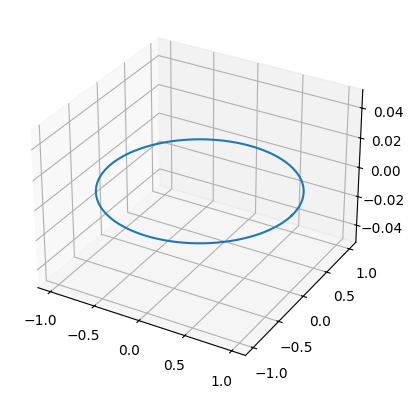

(100, 3)

In [5]:
%matplotlib inline
circle = dl.make_circle()
dl.plot_circle(circle[:,0], circle[:,1])
circle.shape

In [6]:
xyz = dl.make_lorenz()

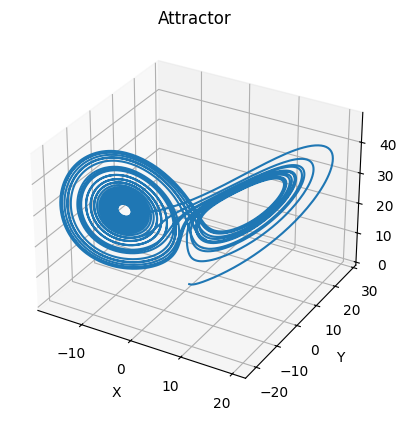

In [7]:
# Plot the Lorenz attractor
dl.plot_lorenz(xyz)

In [8]:
# reshape the lorenz object for use with cebra
lorenz_obj = xyz.reshape(10000,3)
lorenz_obj.shape

(10000, 3)

In [9]:
# ideal model for circle and lorenz inputs
ideal_model, ideal_embedding = base_embed(input=circle, temp=1, dimension=3, lr = 0.1, d=0.1) 
ideal_model_l, ideal_embedding_l = base_embed(input=lorenz_obj, temp=1,dimension=3, lr=0.01, d=1)

pos:  0.0000 neg:  6.2315 total:  6.2315 temperature:  1.0000: 100%|██████████| 2000/2000 [00:24<00:00, 82.43it/s]
pos:  0.0008 neg:  5.9549 total:  5.9558 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 94.74it/s]


<Axes3D: title={'center': 'Lorenz Attractor'}>

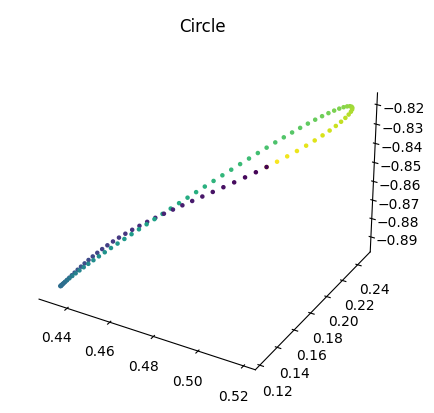

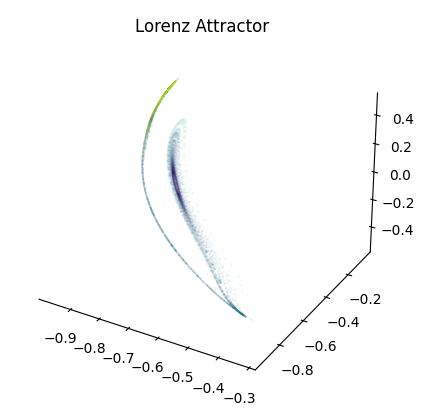

In [10]:
cebra.plot_embedding(ideal_embedding, embedding_labels='time', markersize=5, alpha=1, title='Circle')
cebra.plot_embedding(ideal_embedding_l, embedding_labels='time', markersize=0.001, alpha=1, title='Lorenz Attractor')

Ok, now that we have the outputs of the Models notebook, let's compare the ideal embedding with the top 2 PCs for the Lorenz Attractor. The CEBRA embedding shouldn't be any worse than that

In [14]:
# make a function that compares the top 2 PCs and the CEBRA embedding

def pc_cebra_comp(object, n_iterations = 1):
    
    # Check if the input array has shape (n, m)
    assert object.shape[1] == 3 , f"Input array must have shape 3 columns"

    # define grid
    fig0 = plt.figure(figsize=(8,4*n_iterations))
    gs = gridspec.GridSpec(n_iterations, 2, figure=fig0)

    for i in range(0,n_iterations):

        # make a pca model and fit on the object
        pca = PCA(n_components=2)
        pca.fit(object)

        # compute the PCs and get the explained variance
        object_pca = pca.fit_transform(object)
        explained_var = pca.explained_variance_ratio_

        # compute the cebra embedding using the ideal params learned earlier
        cebra_model, cebra_embedding = base_embed(input=object, temp=1,dimension=3, lr=0.01, d=1)
        
        # make a plot of the 2 PCs of the object
        ax0 = fig0.add_subplot(gs[i,0], projection='3d')
        ax0.scatter(object_pca[:,0], object_pca[:,1], s=0.07)
        ax0.set_title('Top 2 PCs of Lorenz Attractor')

        # plot the cebra embedding
        ax1 = fig0.add_subplot(gs[i,1], projection='3d') 
        cebra.plot_embedding(embedding=cebra_embedding, embedding_labels='time',ax=ax1, markersize=0.001, alpha=1, title='Lorenz Attractor Embedding')
        plt.show()

    return explained_var


pos:  0.0027 neg:  5.6562 total:  5.6589 temperature:  1.0000: 100%|██████████| 2000/2000 [00:22<00:00, 88.45it/s]
pos:  0.0009 neg:  6.0866 total:  6.0875 temperature:  1.0000: 100%|██████████| 2000/2000 [00:22<00:00, 89.57it/s]
pos:  0.0009 neg:  5.8004 total:  5.8013 temperature:  1.0000: 100%|██████████| 2000/2000 [00:22<00:00, 89.56it/s]


array([9.99893149e-01, 1.06431462e-04])

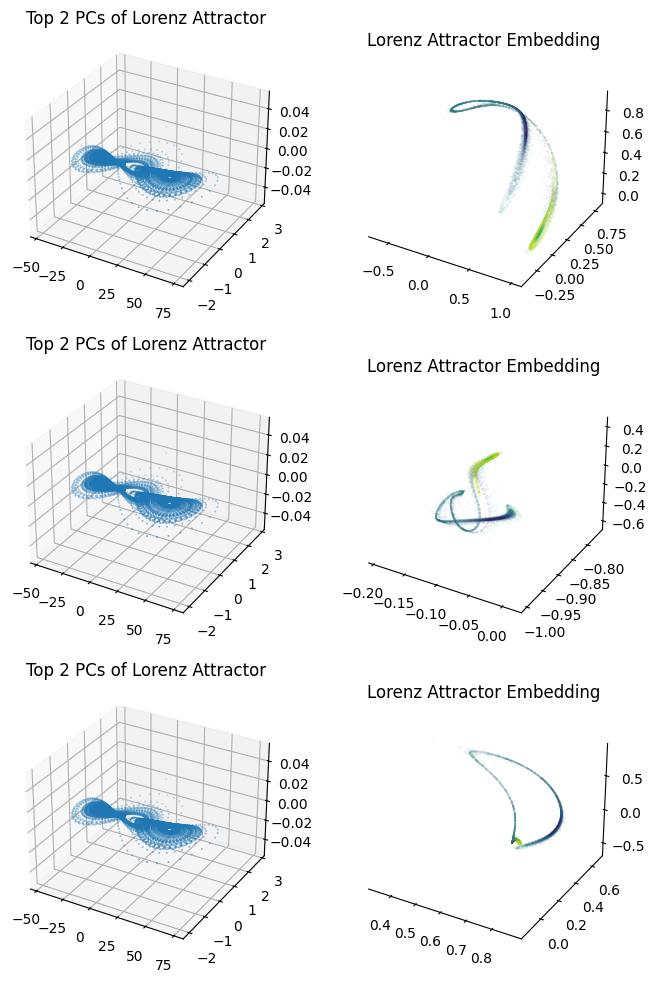

In [13]:
pc_cebra_comp(lorenz_obj,3)

From these figures it looks like the CEBRA embeddings are not in fact consistent for different initializations of models with the same parameters.